In [199]:
# Module imports
import qexpy as q
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bokeh.io import output_notebook
output_notebook(hide_banner=True)
from scipy.stats import chisquare

In [200]:
monochromator_offset = q.Measurement(283, 1, units='nm')
calibration = monochromator_offset - 589.2 
print("Calibration offset", calibration)

lambda_c = 1130
lambda_p = 200
print("Spectral range {} nm  to {} nm"
      .format(lambda_c - lambda_p - 100, lambda_c + lambda_p))

print("Monochromator range {} nm to {} nm"
      .format(lambda_c - lambda_p + calibration - 100, lambda_c + lambda_p + calibration))

Calibration offset -306 +/- 1
Spectral range 830 nm  to 1330 nm
Monochromator range 524 +/- 1 nm to 1024 +/- 1 nm


<IPython.core.display.Javascript object>


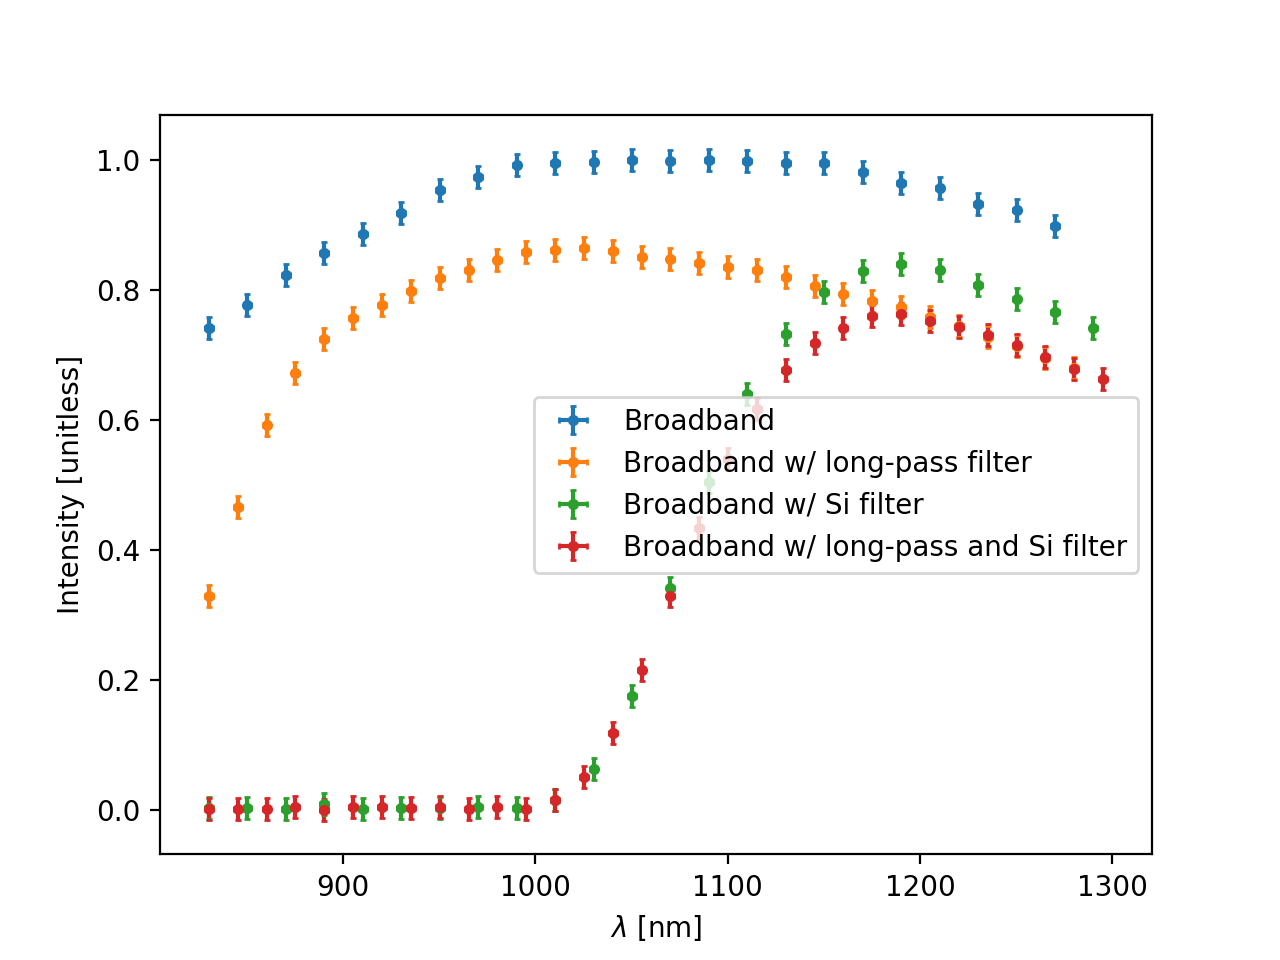

In [201]:
df_si = pd.read_csv(
    './data/spectral_silicon.csv',
    header=None,
    names=['lambda', 'intensity'])
df_py = pd.read_csv(
    './data/spectral_response_broad_pyro.csv',
    header=None,
    names=['lambda', 'intensity'])
df_long = pd.read_csv(
    './data/spectral_long_pass_more_points.csv',
    header=None, 
    names=['lambda', 'intensity'])
df_long_si = pd.read_csv(
    './data/spectral_silicon_long_pass_more_points.csv',
    header=None,
    names=['lambda', 'intensity'])

maxed = np.amax(df_py['intensity'])

plt.figure()
plt.errorbar(
    df_py['lambda'] - calibration.mean,
    df_py['intensity'] / maxed,
    xerr=2*np.ones_like(df_py['lambda']),
    yerr=1e-5*np.ones_like(df_py['lambda']) / maxed,
    capsize=1,
    fmt='.',
    label="Broadband")
plt.errorbar(
    df_long['lambda'] - calibration.mean,
    df_long['intensity'] / maxed,
    xerr=2*np.ones_like(df_long['lambda']),
    yerr=1e-5*np.ones_like(df_long['lambda']) / maxed,
    capsize=1,
    fmt='.',
    label="Broadband w/ long-pass filter")
plt.errorbar(
    df_si['lambda'] - calibration.mean,
    df_si['intensity'] / maxed,
    xerr=2*np.ones_like(df_si['lambda']),
    yerr=1e-5*np.ones_like(df_si['lambda']) / maxed,
    capsize=1,
    fmt='.',
    label="Broadband w/ Si filter")
plt.errorbar(
    df_long_si['lambda'] - calibration.mean,
    df_long_si['intensity'] / maxed,
    xerr=2*np.ones_like(df_long_si['lambda']),
    yerr=1e-5*np.ones_like( df_long_si['lambda']) / maxed,
    capsize=1,
    fmt='.',
    label="Broadband w/ long-pass and Si filter")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Intensity [unitless]")
plt.legend()

#### Analysis

We performed a simple curve fit on the ratio of the the broadband w/ LPF and broadband w/ LPF & Si filters. With simple fitting, we were able to achieve an average Si bandgap of 1.1 eV.

(31,) (31,)


<IPython.core.display.Javascript object>


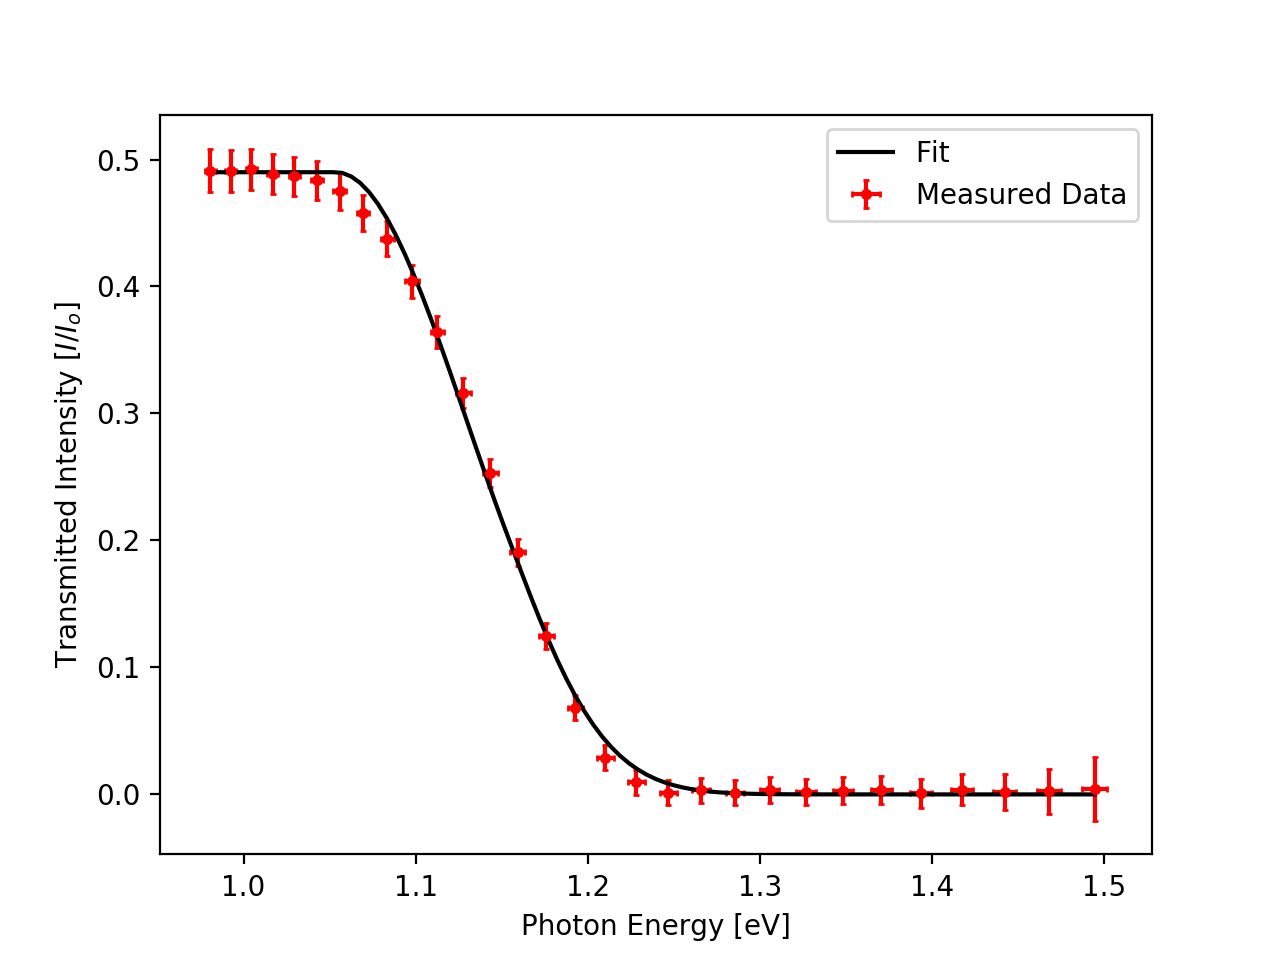

Fit parameters: (R, C, Eg)
C: 1.7072594229670925 +/- 0.14496450503074212
Eg: 1.1037280475949045 +/- 0.003803797338590227
    lambda  intensity
0      524   0.000195
1      539   0.000276
2      554   0.000350
3      569   0.000397
4      584   0.000428
5      599   0.000447
6      614   0.000459
7      629   0.000472
8      644   0.000484
9      659   0.000491
10     674   0.000500
11     689   0.000507
12     704   0.000509
13     719   0.000511
14     734   0.000508
15     749   0.000503
16     764   0.000501
17     779   0.000497
18     794   0.000494
19     809   0.000491
20     824   0.000485
21     839   0.000476
22     854   0.000469
23     869   0.000463
24     884   0.000457
25     899   0.000448
26     914   0.000440
27     929   0.000430
28     944   0.000422
29     959   0.000411
30     974   0.000402


In [203]:
h = 4.136e-15 # eV s
c = 3e17 # nm/s
R = 0.3 
x = 1/1000 # mm

def transmittance(Eph, C, Eg):
    Ep = 0.050
    kB = 8.617 # eV / K
    T = 300 # K
    x = 1/1000 # m
    R = 0.3
    # low alpha
    alpha_low = (Eph - Eg + Ep)**2 / (np.exp(Ep/(kB*T)) - 1)
    # High alpha
    alpha_high =(Eph - Eg + Ep)**2 / (np.exp(Ep/(kB*T)) - 1) + \
                (Eph - Eg - Ep)**2 / (1 - np.exp(-Ep/(kB*T)))
    alpha = np.where(Eph > Ep + Eg, alpha_high, alpha_low)
    alpha[Eph < Eg - Ep] = 0
    
    return (1 - R) ** 2 * np.exp(-C * alpha * x)


Io = q.MeasurementArray(df_long['intensity'].values, 1e-5)
I = (1-0.3)**2 * q.MeasurementArray(df_long_si['intensity'][:-1].values, 1e-5)
print(I.shape, Io.shape)
I_Io = I / Io
wavelengths = q.MeasurementArray(
    (df_long['lambda'] - calibration.mean).values, 4)
energy = h * c / wavelengths

# Curve fitting for phonon assisted absorption
tStart = 0
tEnd = 30
t_popt, t_pcov = \
    curve_fit(transmittance, 
              xdata=energy.means[tStart:tEnd],
              ydata=I_Io.means[tStart:tEnd],
              sigma=I_Io.stds[tStart:tEnd],
              absolute_sigma=True,
              p0=np.array([0.1, 1.1]))
# Plotting
plt.figure()

energyFit = np.linspace(energy.means[tStart], energy.means[tEnd] + 0.01, 100)
transmittance_fit = transmittance(energyFit, t_popt[0], t_popt[1])
plt.errorbar(energy.means[tStart:tEnd], 
             I_Io.means[tStart:tEnd],
             xerr=energy.stds[tStart:tEnd],
             yerr=I_Io.stds[tStart:tEnd],
             fmt='.',
             capsize=1,
             color='red',
             label="Measured Data")
plt.plot(energyFit, 
         transmittance_fit,
         label="Fit",
         color='black')

plt.xlabel("Photon Energy [eV]")
plt.ylabel("Transmitted Intensity [$I/I_o$]")
plt.legend()

C_fit, Eg_fit = t_popt
C_err, Eg_err = np.sqrt(np.diag(t_pcov))
print("Fit parameters: (R, C, Eg)")
print("C: {} +/- {}".format(C_fit, C_err))
print("Eg: {} +/- {}".format(Eg_fit, Eg_err))


print(df_long)

<IPython.core.display.Javascript object>


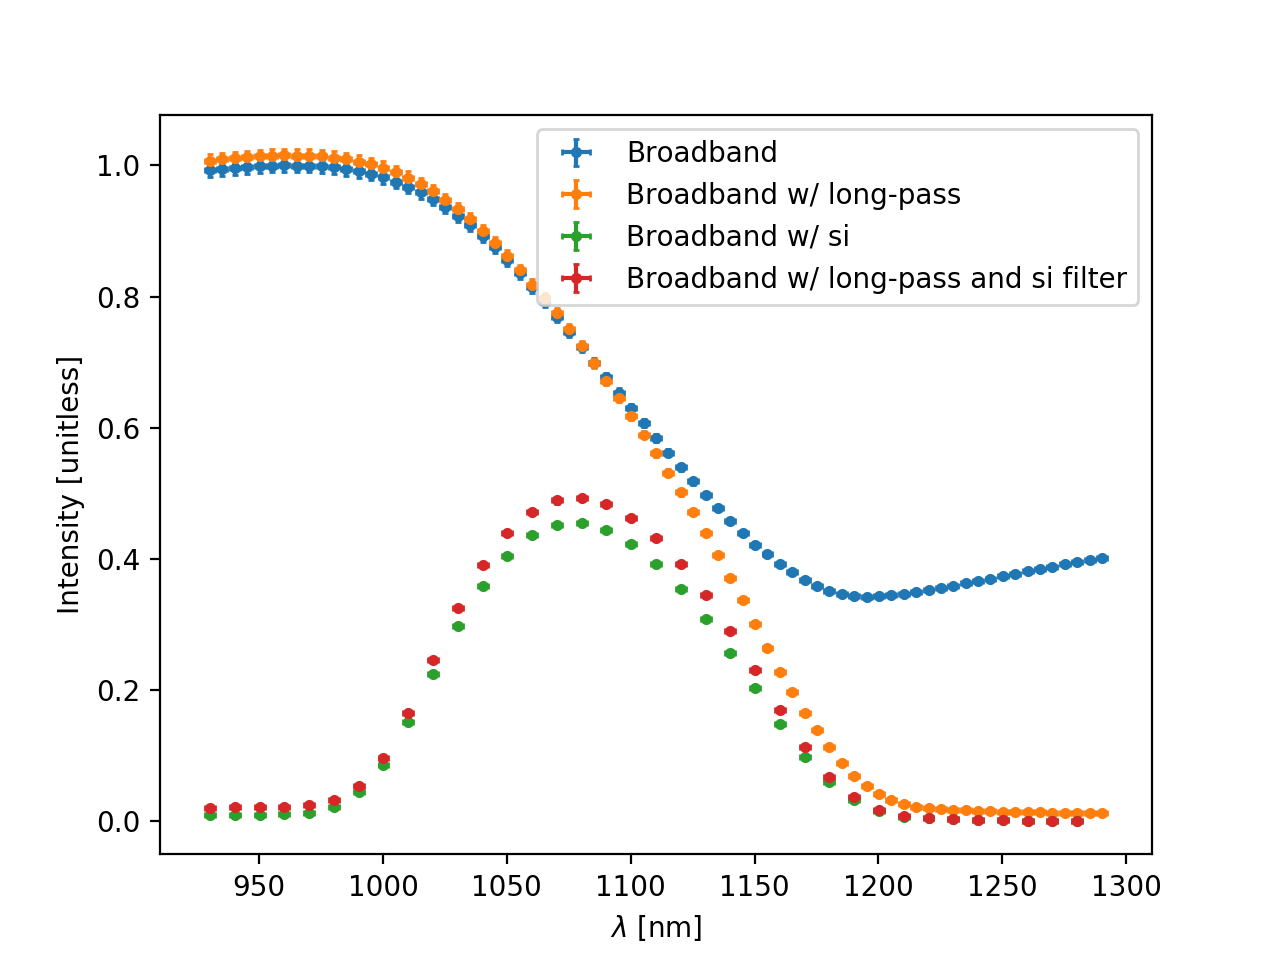

In [46]:
df_diode = pd.read_csv(
    './data/second_experiment_first_collection.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_long = pd.read_csv(
    './data/second_experiment_long_pass_second_run.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_si = pd.read_csv(
    './data/second_experiment_silicon.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_long_si = pd.read_csv(
    './data/second_experiment_silicon_long_pass.csv',
    header=None,
    names=['lambda', 'intensity'])

mmax = np.max(df_diode['intensity'])
    
plt.figure()
plt.errorbar(
    df_diode['lambda'] - calibration.mean,
    df_diode['intensity']/mmax,
    xerr=2*np.ones_like(df_diode['lambda']),
    yerr=0.01*df_diode['intensity']/mmax,
    capsize=1,
    fmt='.',
    label="Broadband")
plt.errorbar(
    df_diode_long['lambda'] - calibration.mean,
    df_diode_long['intensity']/mmax,
    xerr=2*np.ones_like(df_diode_long['lambda']),
    yerr=0.01*df_diode_long['intensity']/mmax,
    capsize=1,
    fmt='.',
    label="Broadband w/ long-pass")
plt.errorbar(
    df_diode_si['lambda'] - calibration.mean,
    df_diode_si['intensity']/mmax,
    xerr=2*np.ones_like(df_diode_si['lambda']),
    yerr=0.01*df_diode_si['intensity']/mmax,
    capsize=1,
    fmt='.',
    label="Broadband w/ si")
plt.errorbar(
    df_diode_long_si['lambda'] - calibration.mean,
    df_diode_long_si['intensity']/mmax,
    xerr=2*np.ones_like(df_diode_long_si['lambda']),
    yerr=0.01*df_diode_long_si['intensity']/mmax,
    capsize=1,
    fmt='.',
    label="Broadband w/ long-pass and si filter")

plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Intensity [unitless]")
plt.legend()

<IPython.core.display.Javascript object>


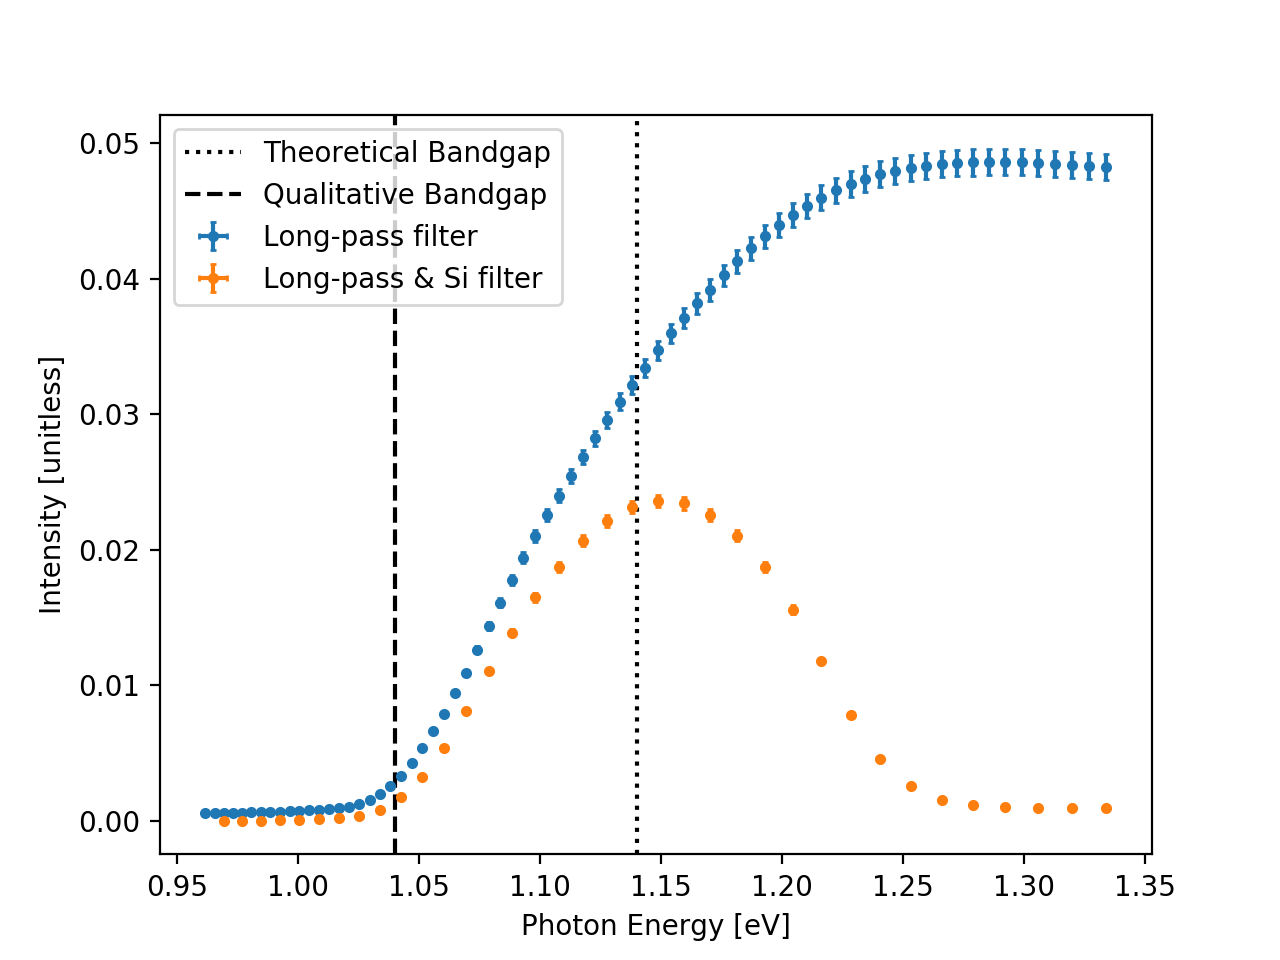

In [51]:
plt.figure()


E_long = h*c / q.MeasurementArray(
    df_diode_long['lambda'].values - calibration.mean, 0.2)
I_long = q.MeasurementArray(
    df_diode_long['intensity'].values, 
    0.02*df_diode_long['intensity'].values)

E_long_si = h*c / q.MeasurementArray(
    df_diode_long_si['lambda'].values - calibration.mean, 0.2)
I_long_si = q.MeasurementArray(
    df_diode_long_si['intensity'].values, 
    0.02*df_diode_long_si['intensity'].values)


plt.errorbar(
    E_long.means,
    I_long.means,
    xerr=E_long.stds,
    yerr=I_long.stds,
    capsize=1,
    fmt='.',
    label="Long-pass filter")
plt.errorbar(
    E_long_si.means,
    I_long_si.means,
    xerr=E_long_si.stds,
    yerr=I_long_si.stds,
    capsize=1,
    fmt='.',
    label="Long-pass & Si filter")

plt.axvline(x=1.14, 
            color='black',
            label="Theoretical Bandgap",
            linestyle=':')
plt.axvline(x=1.04,
            color='black',
            label="Qualitative Bandgap",
            linestyle='--')

plt.xlabel("Photon Energy [eV]")
plt.ylabel("Intensity [unitless]")
plt.legend(loc='best')

### Bandgap Measurement by Resistivity

#### Apparatus
Our apparatus came presetup. We have a computer running Windows XP which is connected to a Keithly 2010 temperature sensor. A thermocouple is connected to the Keithly, whose parallel connects are connected to a cold junction. The silicon sample itself is connected to a four point probe with a Keithly 2400-LV current source. We spent some time understanding out apparatus and how it works. We were able to turn on the oven and have the temperature updated on the thermocouple, albiet without the cold junction.

![heat_diagram](data/app3diagram.png)

#### Experiemental setup
We first put the thermocouple in an icebath with distilled water. We used the front panel temperature, a reading of $0.5$ celsius to calibrate the actual temperature of $0$ celsius. We used a current of 105 micro amps.

#### Initial Results
This was our hystersis plot:

We repeated this experiment many times, since no curve fits seemed to fit our original curve. We noticed that our data was mostly exponential at first, but at high temperatures, we observed a massive jump in resistance. We atrribute this to melding solder, since we were beyond the melting point of 400 celsius. Therefore, our fit will only be done on the expoentnial part of the data.

The following graphs were the exponetial areas that were extracted from the data collection.

In [99]:
def R(T, Eg, A):
    kb = 8.617e-5
    ue = 1/1000 * 2.1e9 * T ** (-2.5)
    uh = 1/1000 * 2.3e9 * T ** (-2.7)
    Eg_T = Eg - (4.73e-4 * T**2) / (T + 636)
    
    return A * np.exp(Eg_T/(2 * kb * T))/((ue + uh)* T**(3/2))


<IPython.core.display.Javascript object>


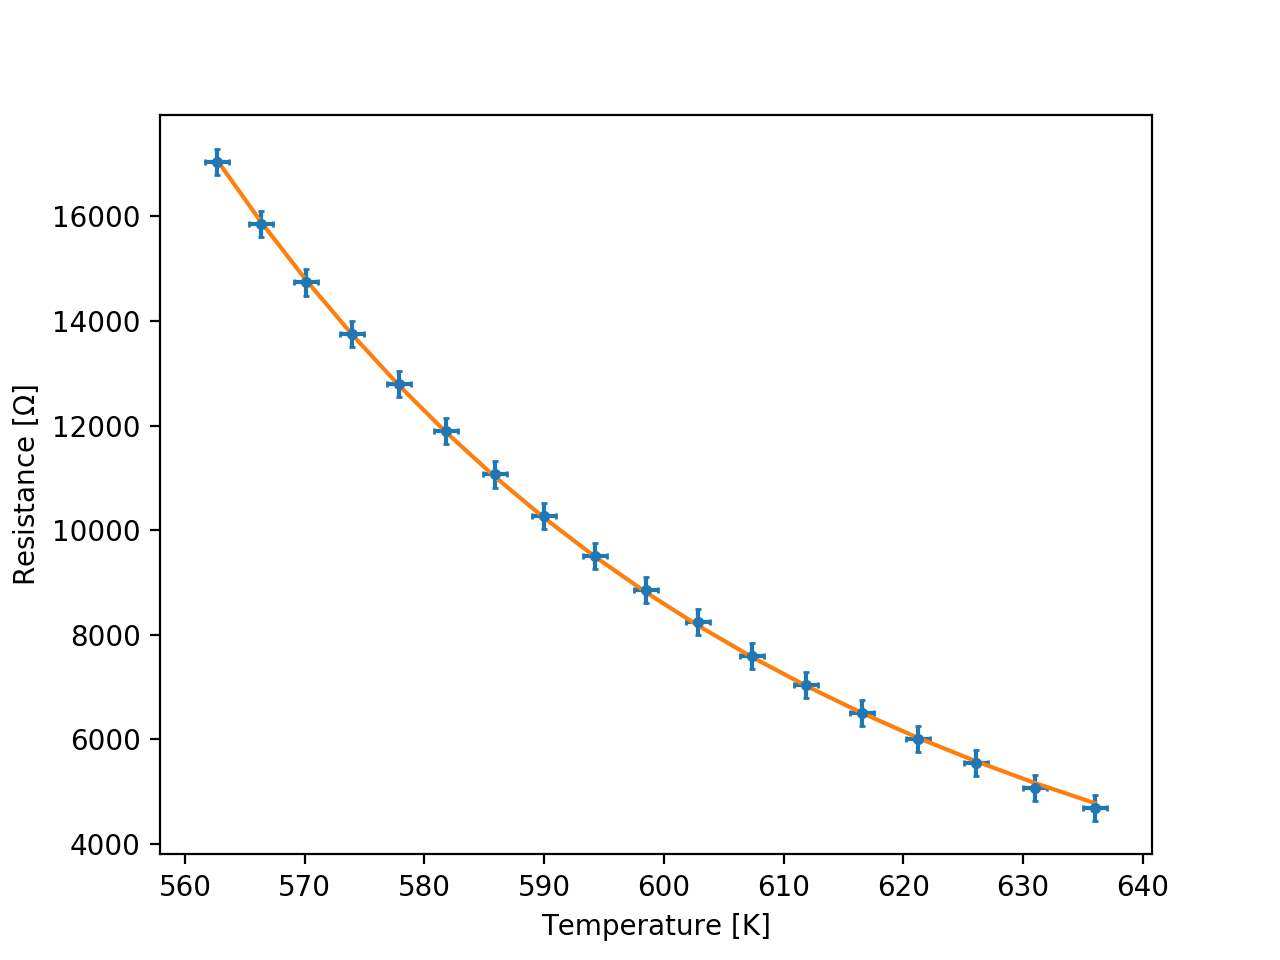

Eg 1.107633370903513 0.036837384209786654
A 3311.9293046171024 1217.6261444745799
Power_divergenceResult(statistic=5.350322339114197, pvalue=0.9965944442974048)


<IPython.core.display.Javascript object>


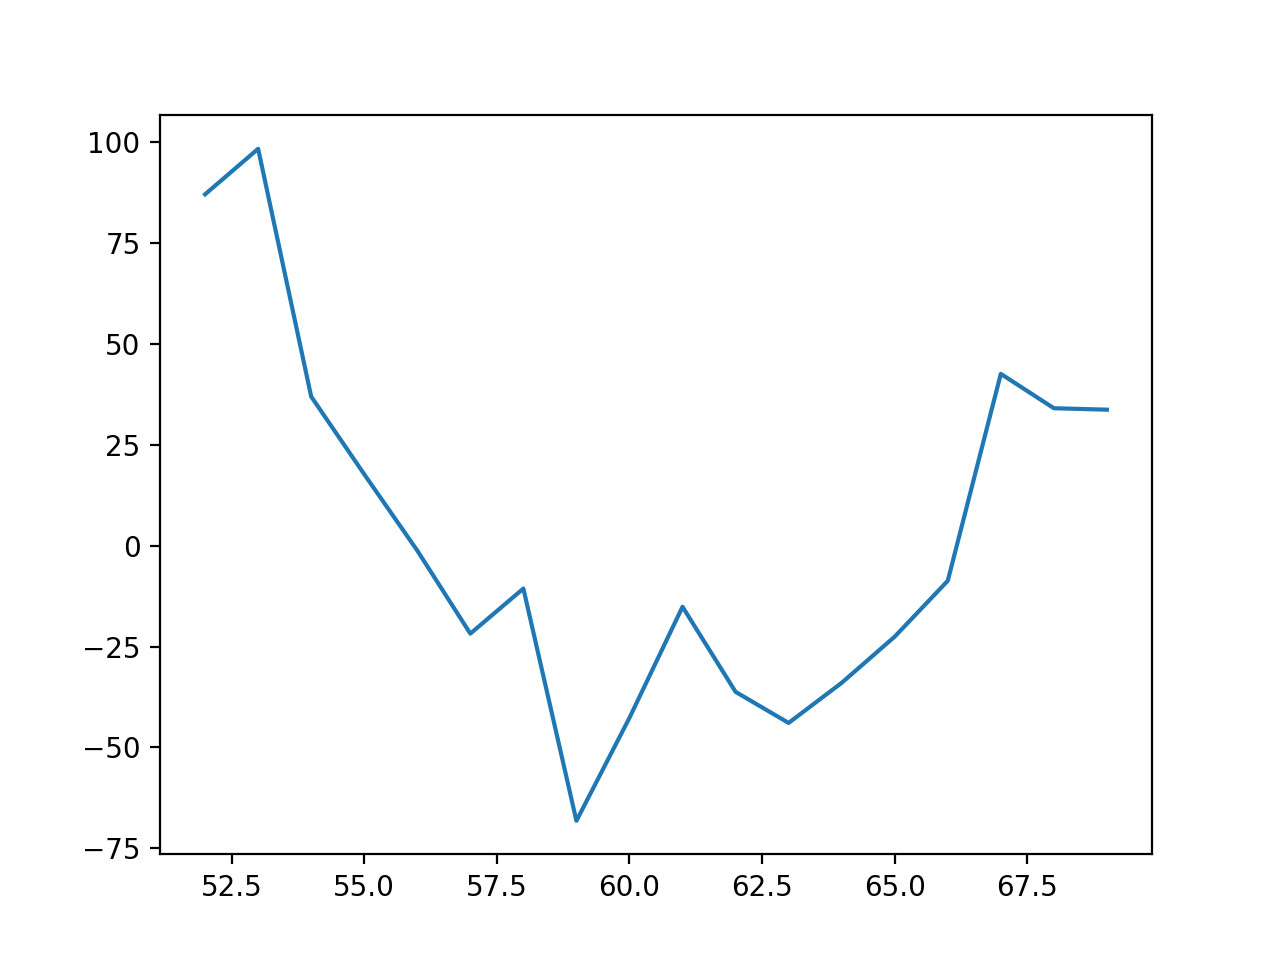

In [110]:
df_temp2 = pd.read_csv('./data/experiment3_2.csv', sep='\t')

startIndex = 52
endIndex = -14
temperature =df_temp2["Temperature"][startIndex:endIndex] + 40
resistance = df_temp2["Resistance"][startIndex:endIndex]

r_popt, r_pcov = curve_fit(R,
          xdata=temperature,
          ydata=resistance,
          sigma=np.ones_like(resistance) * 500,
          absolute_sigma=True,
          p0=np.array([1.16, 2300]))

plt.figure()
plt.errorbar(temperature, resistance,
             xerr=np.ones_like(temperature) * 1,
             yerr=np.ones_like(resistance) * 250,
             fmt='.',
             capsize=1)
plt.plot(temperature, R(temperature, r_popt[0], r_popt[1]))
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

Eg_fit, A_fit = r_popt
Eg_err, A_err = np.sqrt(np.diag(r_pcov))
print("Eg", Eg_fit, Eg_err)
print("A", A_fit, A_err)

resid =  R(temperature, r_popt[0], r_popt[1]) - resistance
chi_sq = chisquare(resistance, R(temperature, r_popt[0], r_popt[1]), ddof=0)
print(chi_sq)

plt.figure()
plt.plot(resid)

<IPython.core.display.Javascript object>


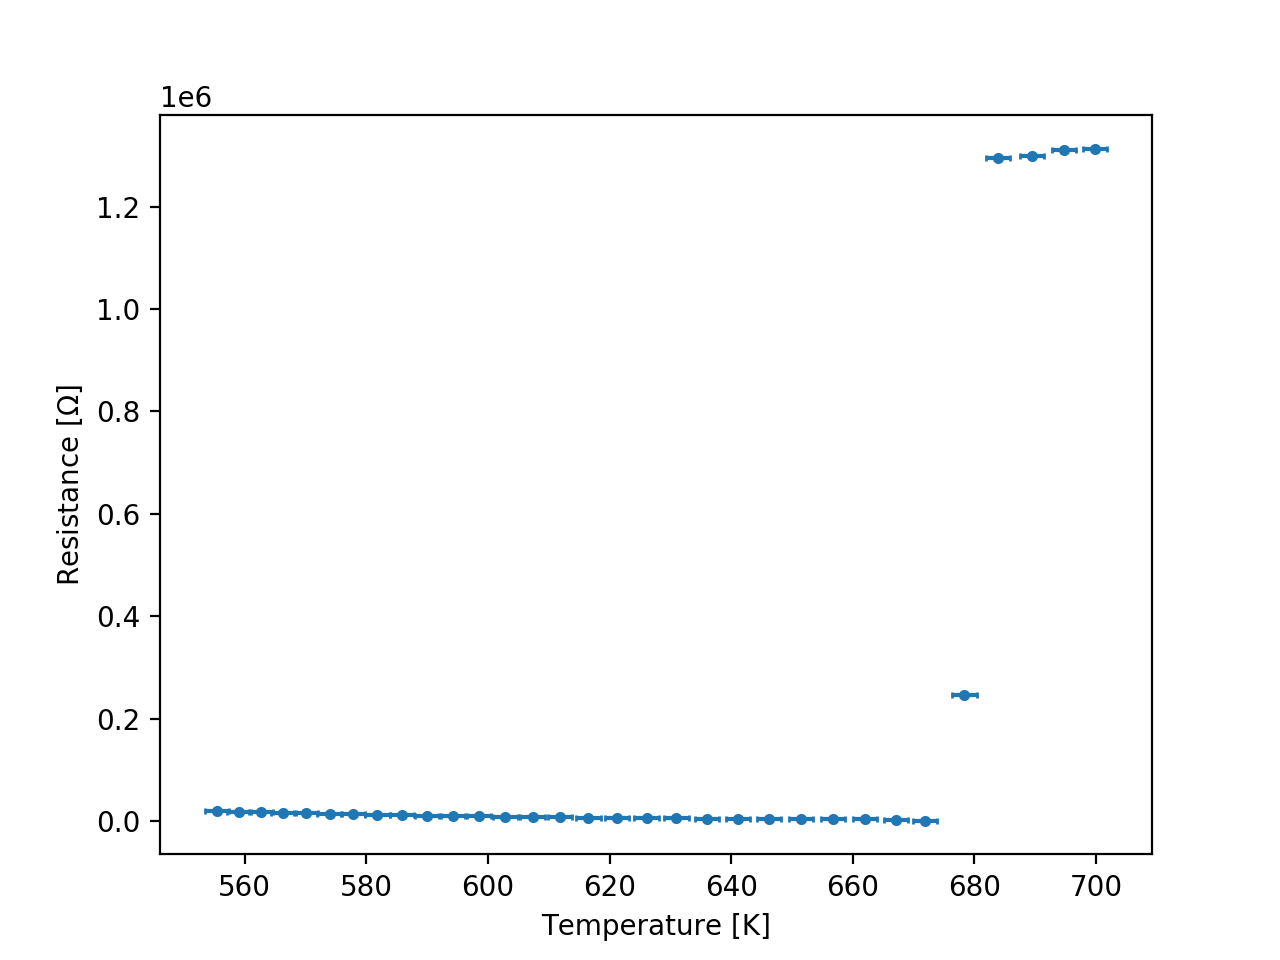

In [88]:
df_temp2 = pd.read_csv('./data/experiment3_2.csv', sep='\t')

startIndex = 40
endIndex = -12
temperature =df_temp2["Temperature"][startIndex:endIndex] + 40
resistance = df_temp2["Resistance"][startIndex:endIndex]

plt.figure()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.errorbar(temperature, resistance,
             xerr=np.ones_like(temperature) * 2,
             yerr=np.ones_like(resistance) * 500,
             fmt='.',
             capsize=1)
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

In [204]:
print(df_temp2[startIndex:endIndex])

    Temperature  Resistance
47      622.023    2866.153
48      616.773    3152.738
49      611.465    3591.826
50      606.259    3836.109
51      601.107    4163.271
52      596.010    4695.356
53      591.015    5067.650
54      586.101    5543.267
55      581.268    6009.570
56      576.543    6507.853
57      571.890    7046.007
58      567.353    7587.801
59      562.885    8241.723
60      558.526    8852.934
61      554.220    9513.533
62      550.005   10271.280
63      545.892   11064.440
64      541.830   11901.720
65      537.868   12792.340
66      533.967   13747.410
67      530.135   14734.040
68      526.366   15855.390
69      522.686   17039.359
70      519.065   18260.070
71      515.497   19505.051
